     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Fetching news articles...
Successfully fetched 10 articles.
PySpark DataFrame created. Sample data:
+----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                     |description                                                                                                                                                     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete: news_sentiment_spark.zip
Generating sentiment distribution plot...


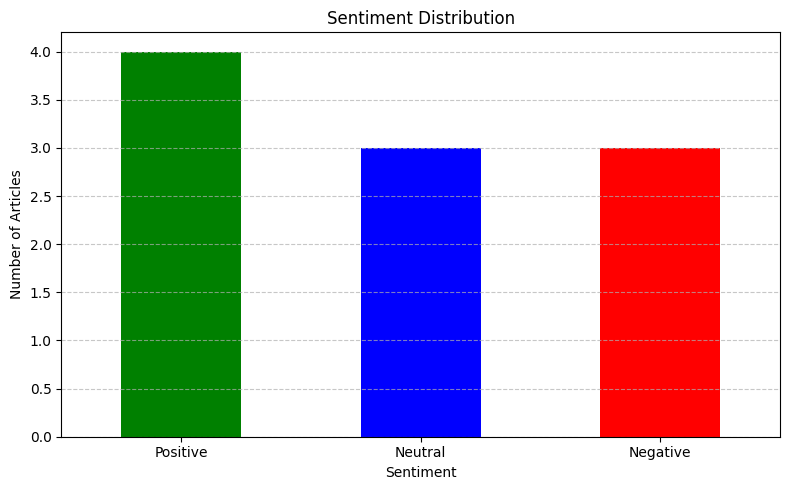

Sentiment distribution plot generated above.
SparkSession stopped.


In [3]:
# Install necessary libraries
!pip install streamlit pyspark requests textblob vaderSentiment

# Download NLTK punkt tokenizer (required by TextBlob)
import nltk
nltk.download('punkt')
import streamlit as st

# Import SparkSession
from pyspark.sql import SparkSession

# Create SparkSession
# It's good practice to stop an existing session if one is running, especially in environments like Colab
try:
    spark.stop()
except NameError:
    pass # SparkSession not yet created

spark = SparkSession.builder \
    .appName("News Sentiment Analysis") \
    .getOrCreate()

import requests
from pyspark.sql.types import StructType, StructField, StringType
from textblob import TextBlob
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import shutil # For zipping files
from google.colab import files # For downloading files in Colab

# --- 1. Ingestion Method: Fetch News Data ---
api_key = '399177fa64cba6c7f874fcee674f6c82' # Replace with your actual GNews API key
query = 'India'
url = f'https://gnews.io/api/v4/search?q={query}&lang=en&apikey={api_key}'

print("Fetching news articles...")
# Make API call
response = requests.get(url)

# Extract data
if response.status_code == 200:
    data = response.json()
    articles = data.get('articles', [])
    print(f"Successfully fetched {len(articles)} articles.")
else:
    print(f"Error fetching news: {response.status_code} - {response.text}")
    articles = []

# --- 2. Create PySpark DataFrame ---
# Define schema
schema = StructType([
    StructField("title", StringType(), True),
    StructField("description", StringType(), True),
    StructField("publishedAt", StringType(), True),
    StructField("url", StringType(), True)
])

# Create Spark DataFrame from fetched articles
if articles:
    news_rdd = spark.sparkContext.parallelize([
        (article.get('title'), article.get('description'), article.get('publishedAt'), article.get('url'))
        for article in articles
    ])
    df = spark.createDataFrame(news_rdd, schema)
    print("PySpark DataFrame created. Sample data:")
    df.show(5, truncate=False)
else:
    print("No articles to process. Creating an empty DataFrame.")
    df = spark.createDataFrame([], schema) # Create an empty DataFrame if no articles


# --- 3. Sentiment Analysis Logic: TextBlob Sentiment UDF ---
# Define UDF for TextBlob Sentiment
def textblob_sentiment(text):
    if text:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0:
            return "Positive"
        elif polarity < 0:
            return "Negative"
        else:
            return "Neutral"
    return "Neutral" # Default for empty or None text

# Register UDF
sentiment_udf = udf(textblob_sentiment, StringType())

# Apply sentiment analysis to the 'title' column
if not df.isEmpty():
    df_sentiment = df.withColumn("sentiment", sentiment_udf(df["title"]))
    print("Sentiment analysis applied to titles. Sample with sentiment:")
    df_sentiment.select("title", "sentiment").show(5, truncate=False)

    # --- 4. Export Results (Optional, for saving to file) ---
    output_csv_path = "news_sentiment_spark.csv"
    print(f"Saving sentiment results to '{output_csv_path}'...")
    # Coalesce to 1 partition to get a single CSV file, useful for small datasets
    df_sentiment.coalesce(1).write.csv(output_csv_path, header=True, mode='overwrite')
    print("Results saved. Zipping and preparing for download...")

    # For Google Colab: Zipping and downloading the file
    # Note: Spark writes CSV to a directory, so we need to find the actual CSV file
    import glob
    csv_files = glob.glob(f"{output_csv_path}/part-*.csv")
    if csv_files:
        single_csv_file = csv_files[0]
        shutil.copy(single_csv_file, "news_sentiment_spark_single.csv") # Copy to a known name
        shutil.make_archive("news_sentiment_spark", 'zip', ".", "news_sentiment_spark_single.csv")
        files.download("news_sentiment_spark.zip")
        print("Download complete: news_sentiment_spark.zip")
    else:
        print("No CSV part file found to zip.")


    # --- 5. Visualization Features ---
    print("Generating sentiment distribution plot...")
    # Calculate sentiment counts
    sentiment_counts_df = df_sentiment.groupBy("sentiment").count()

    # Convert to pandas for plotting
    sentiment_counts_pd = sentiment_counts_df.toPandas()

    if not sentiment_counts_pd.empty:
        # Set 'sentiment' column as index for plotting
        sentiment_counts = sentiment_counts_pd.set_index('sentiment')['count']

        # Bar graph
        fig, ax = plt.subplots(figsize=(8, 5))
        sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'], ax=ax)
        ax.set_title('Sentiment Distribution')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Number of Articles')
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("Sentiment distribution plot generated above.")
    else:
        print("No sentiment data available to generate a plot.")

else:
    print("No articles were processed for sentiment analysis or visualization.")

# Stop SparkSession
spark.stop()
print("SparkSession stopped.")